In [1]:
import os
import random
from collections import Counter

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

In [2]:
if not os.path.exists('monetPicasso'):
    !wget https://raw.githubusercontent.com/celioboulay/IMA206/main/monetPicasso.zip
    !unzip -q monetPicasso.zip
    !ls

--2025-05-20 15:06:34--  https://raw.githubusercontent.com/celioboulay/IMA206/main/monetPicasso.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10242036 (9.8M) [application/zip]
Saving to: ‘monetPicasso.zip’

monetPicasso.zip    100%[===================>]   9.77M  --.-KB/s    in 0.03s   

2025-05-20 15:06:35 (333 MB/s) - ‘monetPicasso.zip’ saved [10242036/10242036]

__MACOSX  monetPicasso	monetPicasso.zip  sample_data


On utilise une partie du dataset wikiart, on garde les oeuvres de Monet et Picasso.

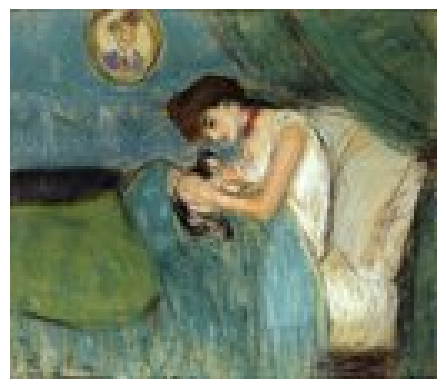

In [3]:
img = Image.open('monetPicasso/picasso/pablo-picasso_woman-with-cat-1900.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

## Création des datasets

Number of images in the dataset: 1844
Classes: ['monet', 'picasso']
Batch image tensor shape: torch.Size([4, 3, 256, 256])
Batch labels: tensor([0, 0, 0, 0])


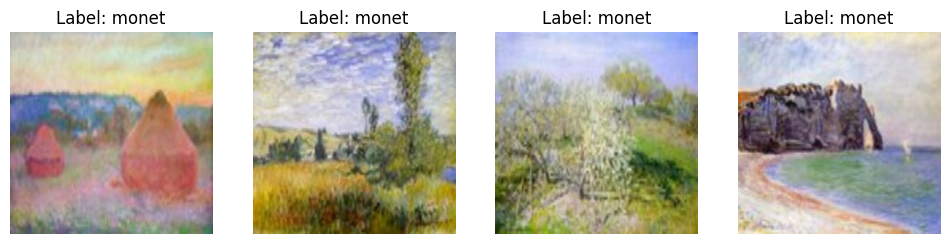

In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()          # PIL -> PyTorch Tensor
])



image_folder_path = 'monetPicasso/'
dataset = datasets.ImageFolder(root=image_folder_path, transform=transform)

batch_size = 4
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True) # dataLoader pour parcourir la database


print(f"Number of images in the dataset: {len(dataset)}")
print(f"Classes: {dataset.classes}") # inferred classes


images, labels = next(iter(dataloader))

print(f"Batch image tensor shape: {images.shape}") # [batch_size, channels, height, width]



fig, axes = plt.subplots(1, batch_size, figsize=(12, 4))
for i in range(batch_size):
    img = images[i].permute(1, 2, 0).numpy() # torch tensors de forme [C, H, W] mais matplotlib veut [H, W, C] pour l'affichage
    ax = axes[i]
    ax.imshow(img)
    ax.set_title(f"Label: {dataset.classes[labels[i]]}")
    ax.axis('off')
plt.show()

In [5]:
labels = np.array(dataset.targets)
class_0_indices = np.where(labels == 0)[0]
class_1_indices = np.where(labels == 1)[0]
n_samples_per_class = min(len(class_0_indices), len(class_1_indices))  # forcer l'égalité des classes, y a forcément mieux à faire dans cette partie, à revoir

random.seed(42)
np.random.shuffle(class_0_indices)
np.random.shuffle(class_1_indices)

# split sizes
train_size_per_class = int(0.7 * n_samples_per_class)
valid_size_per_class = int(0.15 * n_samples_per_class)
test_size_per_class  = n_samples_per_class - train_size_per_class - valid_size_per_class

# indices
train_indices = np.concatenate((class_0_indices[:train_size_per_class],class_1_indices[:train_size_per_class]))

valid_indices = np.concatenate((class_0_indices[train_size_per_class:train_size_per_class + valid_size_per_class],class_1_indices[train_size_per_class:train_size_per_class + valid_size_per_class]))

test_indices = np.concatenate((class_0_indices[train_size_per_class + valid_size_per_class:], class_1_indices[train_size_per_class + valid_size_per_class:]))


np.random.shuffle(train_indices)
np.random.shuffle(valid_indices)
np.random.shuffle(test_indices)

# datasets de la bonne taille
train_dataset = Subset(dataset, train_indices)
valid_dataset = Subset(dataset, valid_indices)
test_dataset  = Subset(dataset, test_indices)

# labels pour vérif
train_labels = labels[train_indices]
valid_labels = labels[valid_indices]
test_labels  = labels[test_indices]


print(f"Train class counts: {Counter(train_labels)}")
print(f"Valid class counts: {Counter(valid_labels)}")
print(f"Test class counts:  {Counter(test_labels)}")


# dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Train class counts: Counter({np.int64(0): 357, np.int64(1): 357})
Valid class counts: Counter({np.int64(1): 76, np.int64(0): 76})
Test class counts:  Counter({np.int64(0): 901, np.int64(1): 77})


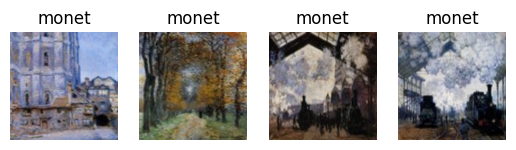

In [6]:
for idx in range(0,4):
    plt.subplot(1,4, idx+1)
    img, label = dataset[random.choice(test_indices)]
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.title(dataset.classes[label])
    plt.axis('off')
plt.show()

# Architecture

faut que je mette un diagramme

In [7]:
nb_channels = 3
nb_classes = 2
learning_rate = 1e-3
n_epochs = 25

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(

            nn.Conv2d(nb_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (256 // 8) * (256 // 8), 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, nb_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate model
model = SimpleCNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Normalisation à appliquer sur le DataLoader
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


Using device: cuda


In [13]:
train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for data, target in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{n_epochs}"):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

    train_accuracy = correct / total
    avg_train_loss = train_loss / len(train_dataloader)

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}')

    # Validation
    model.eval()
    valid_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data, target in valid_dataloader:
            data, target = data.to(device), target.to(device)

            outputs = model(data)
            loss = criterion(outputs, target)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == target).sum().item()
            total_val += target.size(0)

    valid_accuracy = correct_val / total_val
    avg_valid_loss = valid_loss / len(valid_dataloader)

    print(f'Validation Loss: {avg_valid_loss:.4f}, Validation Acc: {valid_accuracy:.4f}\n')


Epoch 1/25: 100%|██████████| 179/179 [00:03<00:00, 49.52it/s]


Epoch 1, Train Loss: 0.3264, Train Acc: 0.8796
Validation Loss: 0.6550, Validation Acc: 0.8947



Epoch 2/25: 100%|██████████| 179/179 [00:03<00:00, 50.16it/s]


Epoch 2, Train Loss: 0.3125, Train Acc: 0.8852
Validation Loss: 0.4404, Validation Acc: 0.8553



Epoch 3/25: 100%|██████████| 179/179 [00:03<00:00, 46.45it/s]


Epoch 3, Train Loss: 0.3450, Train Acc: 0.8529
Validation Loss: 0.6255, Validation Acc: 0.8750



Epoch 4/25: 100%|██████████| 179/179 [00:03<00:00, 50.25it/s]


Epoch 4, Train Loss: 0.3091, Train Acc: 0.8796
Validation Loss: 0.4419, Validation Acc: 0.8487



Epoch 5/25: 100%|██████████| 179/179 [00:03<00:00, 45.78it/s]


Epoch 5, Train Loss: 0.3324, Train Acc: 0.8711
Validation Loss: 0.8689, Validation Acc: 0.8684



Epoch 6/25: 100%|██████████| 179/179 [00:04<00:00, 41.41it/s]


Epoch 6, Train Loss: 0.2571, Train Acc: 0.9132
Validation Loss: 0.4410, Validation Acc: 0.8882



Epoch 7/25: 100%|██████████| 179/179 [00:03<00:00, 50.40it/s]


Epoch 7, Train Loss: 0.2745, Train Acc: 0.8992
Validation Loss: 0.4759, Validation Acc: 0.8882



Epoch 8/25: 100%|██████████| 179/179 [00:03<00:00, 50.41it/s]


Epoch 8, Train Loss: 0.3210, Train Acc: 0.8711
Validation Loss: 0.5731, Validation Acc: 0.8618



Epoch 9/25: 100%|██████████| 179/179 [00:03<00:00, 46.02it/s]


Epoch 9, Train Loss: 0.2742, Train Acc: 0.9006
Validation Loss: 0.6643, Validation Acc: 0.8618



Epoch 10/25: 100%|██████████| 179/179 [00:03<00:00, 50.31it/s]


Epoch 10, Train Loss: 0.2791, Train Acc: 0.8950
Validation Loss: 0.6192, Validation Acc: 0.8684



Epoch 11/25: 100%|██████████| 179/179 [00:03<00:00, 50.65it/s]


Epoch 11, Train Loss: 0.2718, Train Acc: 0.8978
Validation Loss: 0.4812, Validation Acc: 0.8882



Epoch 12/25: 100%|██████████| 179/179 [00:03<00:00, 45.92it/s]


Epoch 12, Train Loss: 0.2878, Train Acc: 0.8936
Validation Loss: 0.7829, Validation Acc: 0.8553



Epoch 13/25: 100%|██████████| 179/179 [00:03<00:00, 47.47it/s]


Epoch 13, Train Loss: 0.2864, Train Acc: 0.8922
Validation Loss: 0.5122, Validation Acc: 0.9013



Epoch 14/25: 100%|██████████| 179/179 [00:03<00:00, 47.30it/s]


Epoch 14, Train Loss: 0.3079, Train Acc: 0.8782
Validation Loss: 0.4743, Validation Acc: 0.9079



Epoch 15/25: 100%|██████████| 179/179 [00:04<00:00, 38.18it/s]


Epoch 15, Train Loss: 0.3194, Train Acc: 0.8739
Validation Loss: 0.4485, Validation Acc: 0.8947



Epoch 16/25: 100%|██████████| 179/179 [00:04<00:00, 37.09it/s]


Epoch 16, Train Loss: 0.2714, Train Acc: 0.9048
Validation Loss: 0.4314, Validation Acc: 0.8882



Epoch 17/25: 100%|██████████| 179/179 [00:04<00:00, 42.15it/s]


Epoch 17, Train Loss: 0.2815, Train Acc: 0.9048
Validation Loss: 0.4787, Validation Acc: 0.8750



Epoch 18/25: 100%|██████████| 179/179 [00:03<00:00, 49.87it/s]


Epoch 18, Train Loss: 0.2774, Train Acc: 0.8964
Validation Loss: 0.6344, Validation Acc: 0.8553



Epoch 19/25: 100%|██████████| 179/179 [00:04<00:00, 44.21it/s]


Epoch 19, Train Loss: 0.2653, Train Acc: 0.9034
Validation Loss: 0.4086, Validation Acc: 0.8816



Epoch 20/25: 100%|██████████| 179/179 [00:04<00:00, 38.41it/s]


Epoch 20, Train Loss: 0.2921, Train Acc: 0.8866
Validation Loss: 0.4298, Validation Acc: 0.8882



Epoch 21/25: 100%|██████████| 179/179 [00:03<00:00, 47.34it/s]


Epoch 21, Train Loss: 0.2350, Train Acc: 0.9202
Validation Loss: 0.5500, Validation Acc: 0.9013



Epoch 22/25: 100%|██████████| 179/179 [00:03<00:00, 47.92it/s]


Epoch 22, Train Loss: 0.2657, Train Acc: 0.9020
Validation Loss: 0.4529, Validation Acc: 0.8816



Epoch 23/25: 100%|██████████| 179/179 [00:04<00:00, 43.84it/s]


Epoch 23, Train Loss: 0.2654, Train Acc: 0.9020
Validation Loss: 0.5317, Validation Acc: 0.8750



Epoch 24/25: 100%|██████████| 179/179 [00:03<00:00, 49.71it/s]


Epoch 24, Train Loss: 0.3257, Train Acc: 0.8711
Validation Loss: 0.4122, Validation Acc: 0.8684



Epoch 25/25: 100%|██████████| 179/179 [00:03<00:00, 47.24it/s]


Epoch 25, Train Loss: 0.2674, Train Acc: 0.9006
Validation Loss: 0.3954, Validation Acc: 0.8947



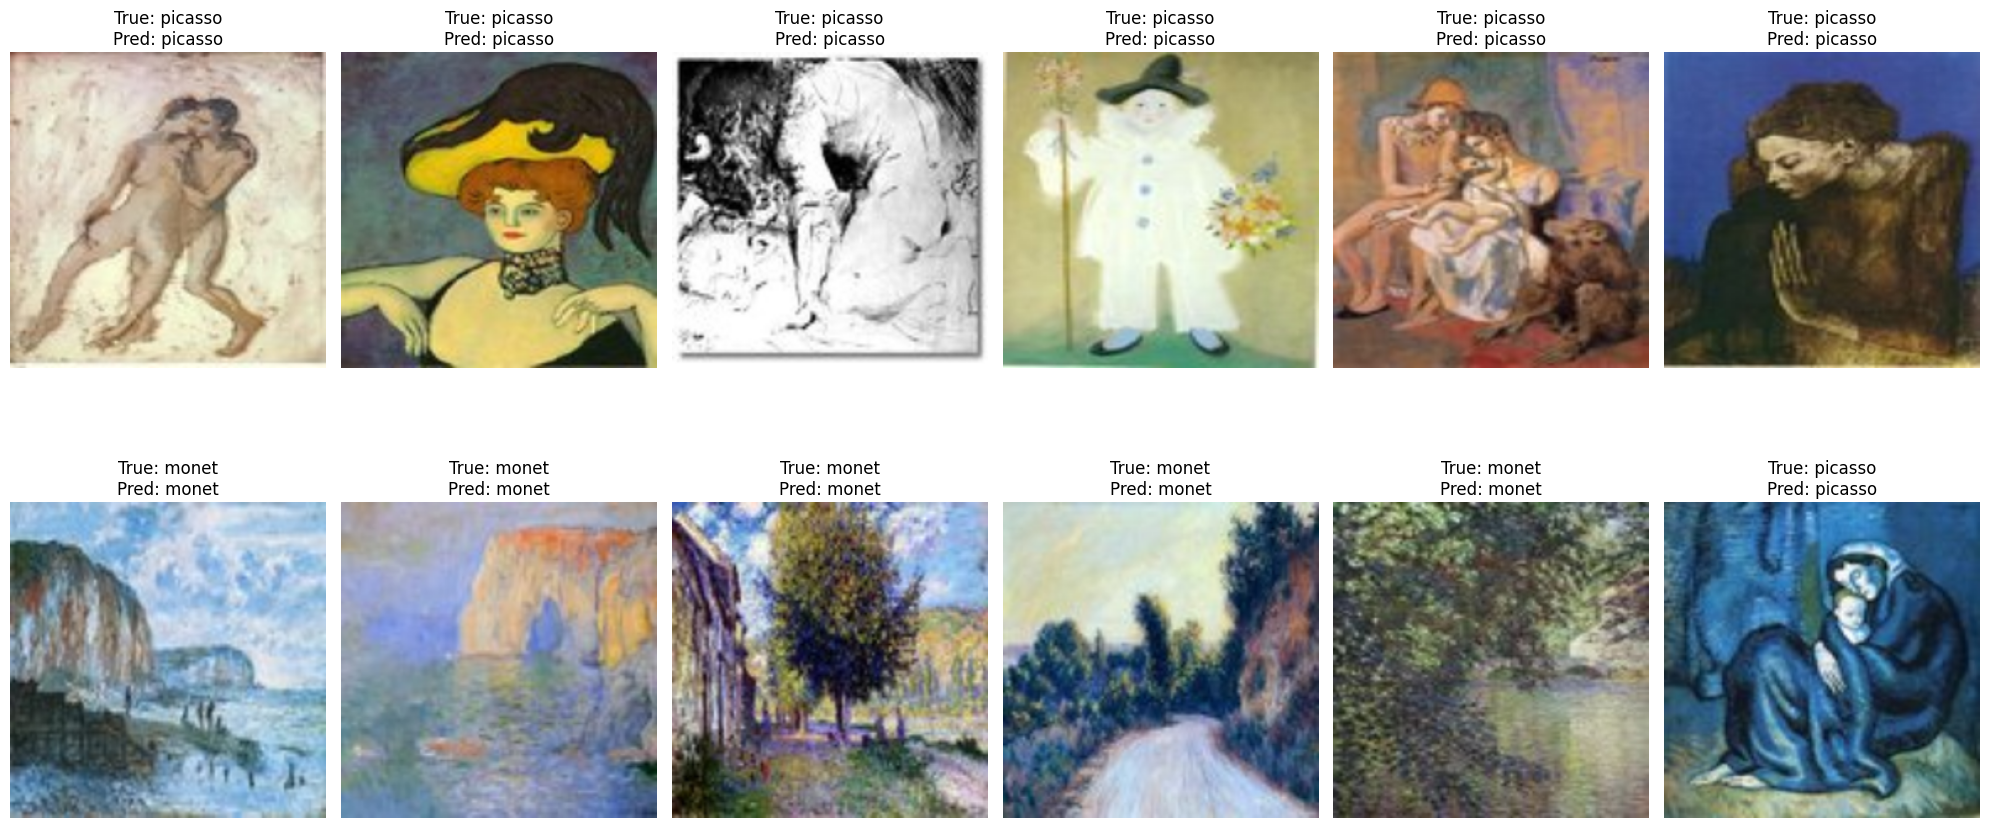

In [17]:
monet_test_indices = [i for i in test_indices if dataset.targets[i] == 0]   # utilisé Gemini pour la visualisation
picasso_test_indices = [i for i in test_indices if dataset.targets[i] == 1]

selected_monet_indices = random.sample(monet_test_indices, min(10, len(monet_test_indices)))
selected_picasso_indices = random.sample(picasso_test_indices, min(10, len(picasso_test_indices)))

selected_test_indices = selected_monet_indices + selected_picasso_indices
random.shuffle(selected_test_indices)

model.eval()
with torch.no_grad():
    fig, axes = plt.subplots(nrows=2, ncols=max(10, 10)//2 + 1, figsize=(20, 10))
    axes = axes.flatten()

    for i, idx in enumerate(selected_test_indices):
        if i >= len(axes):
            break

        img, label = dataset[idx]
        img_input = img.unsqueeze(0).to(device)
        output = model(img_input)
        _, predicted = torch.max(output, 1)
        predicted_class = dataset.classes[predicted.item()]
        true_class = dataset.classes[label]

        ax = axes[i]
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.set_title(f'True: {true_class}\nPred: {predicted_class}')
        ax.axis('off')


    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()